In [13]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
from seaborn import countplot,lineplot, barplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from bayes_opt import BayesianOptimization
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, GroupShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
import math
from itertools import chain


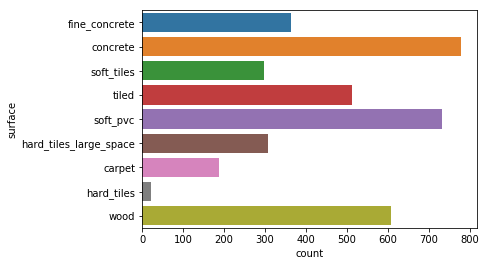

In [4]:
def quaternion_to_euler(x, y, z, w):

    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

def fe(actual):
    new = pd.DataFrame()
    actual['total_angular_velocity'] = np.sqrt(np.square(actual['angular_velocity_X']) + 
                                        np.square(actual['angular_velocity_Y']) + 
                                        np.square(actual['angular_velocity_Z']))
    actual['total_linear_acceleration'] = np.sqrt(np.square(actual['linear_acceleration_X']) + 
                                            np.square(actual['linear_acceleration_Y']) + 
                                            np.square(actual['linear_acceleration_Z']))
    
    actual['acc_vs_vel'] = actual['total_linear_acceleration'] / actual['total_angular_velocity']
    
    x, y, z, w = actual['orientation_X'].tolist(), actual['orientation_Y'].tolist(), actual['orientation_Z'].tolist(), actual['orientation_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz
    
    def f1(x):
        return np.mean(np.diff(np.abs(np.diff(x))))
    
    def f2(x):
        return np.mean(np.abs(np.diff(x)))
    
    for col in actual.columns:
        if col in ['row_id', 'series_id', 'measurement_number']:
            continue
        new[col + '_mean'] = actual.groupby(['series_id'])[col].mean()
        new[col + '_min'] = actual.groupby(['series_id'])[col].min()
        new[col + '_max'] = actual.groupby(['series_id'])[col].max()
        new[col + '_std'] = actual.groupby(['series_id'])[col].std()
        new[col + '_max_to_min'] = new[col + '_max'] / new[col + '_min']
        
        # Change. 1st order.
        new[col + '_mean_abs_change'] = actual.groupby('series_id')[col].apply(f2)
        
        # Change of Change. 2nd order.
        new[col + '_mean_change_of_abs_change'] = actual.groupby('series_id')[col].apply(f1)
        
        new[col + '_abs_max'] = actual.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
        new[col + '_abs_min'] = actual.groupby('series_id')[col].apply(lambda x: np.min(np.abs(x)))

    return new


X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
SS = pd.read_csv('sample_submission.csv')

X_train.head()
countplot(y = 'surface', data = y_train)
plt.show()

In [5]:
# Augment hard tiles. 
# print((y_train['surface'] == 'hard_tiles'))

In [6]:
le = LabelEncoder()
y_train['surface'] = le.fit_transform(y_train['surface'])

X_train = fe(X_train)
X_test = fe(X_test)

# Imputation   
X_train.fillna(0, inplace = True)
X_test.fillna(0, inplace = True)

X_train.replace(-np.inf, 0, inplace = True)
X_train.replace(np.inf, 0, inplace = True)
X_test.replace(-np.inf, 0, inplace = True)
X_test.replace(np.inf, 0, inplace = True)
X_train.head()

,orientation_X_mean,orientation_X_min,orientation_X_max,orientation_X_std,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_mean_change_of_abs_change,orientation_X_abs_max,orientation_X_abs_min,orientation_Y_mean,...,euler_y_abs_min,euler_z_mean,euler_z_min,euler_z_max,euler_z_std,euler_z_max_to_min,euler_z_mean_abs_change,euler_z_mean_change_of_abs_change,euler_z_abs_max,euler_z_abs_min
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.75953,-0.75822,0.000363,0.998275,0.000015,2.380952e-07,0.75953,0.75822,-0.634008,...,0.023562,1.396035,1.393233,1.397402,0.001221,1.002992,0.000051,1.602451e-07,1.397402,1.393233
1,-0.958606,-0.95896,-0.95837,0.000151,0.999385,0.000023,-4.761905e-07,0.95896,0.95837,0.241867,...,0.009109,-0.492731,-0.494641,-0.490164,0.001131,0.990949,0.000147,1.303804e-07,0.494641,0.490164
2,-0.512057,-0.51434,-0.50944,0.001377,0.990473,0.000041,0.000000e+00,0.51434,0.50944,-0.846171,...,0.011795,2.055021,2.049684,2.061288,0.003219,1.005661,0.000097,-8.169853e-07,2.061288,2.049684
3,-0.939169,-0.93968,-0.93884,0.000227,0.999106,0.000026,-6.349206e-07,0.93968,0.93884,0.310140,...,0.014645,-0.635656,-0.638340,-0.634294,0.000931,0.993661,0.000071,9.790398e-08,0.638340,0.634294
4,-0.891301,-0.89689,-0.88673,0.002955,0.988672,0.000080,7.936508e-08,0.89689,0.88673,0.428144,...,0.009358,-0.894147,-0.915040,-0.867983,0.013836,0.948575,0.000371,4.805791e-07,0.915040,0.867983


In [18]:

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest Accuracy: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))

# Classifier
bayes_cv_tuner = BayesSearchCV(
    estimator = RandomForestClassifier(
        criterion='gini',
        verbose=1,
        max_features='auto',
        max_leaf_nodes=None,
        random_state = 1337
        
    ),
    search_spaces = { 
        'max_depth': (1, 200),
        'n_estimators': (20, 300),
        'min_samples_split': (2,20),
        'min_samples_leaf': (1,10),
        'min_weight_fraction_leaf': (0.0,0.5),
        'min_impurity_decrease': (0,1E-7),
        
        
    },    
    cv = StratifiedKFold(n_splits=split_count, shuffle=True, random_state=546789),
    n_jobs = -1,
    n_iter = 40,   
    verbose = 1,
    refit = True,
    
)

# Fit the model
result = bayes_cv_tuner.fit(X_train, y_train['surface'], groups=y_train['group_id'], callback=status_print)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Model #1
Best Accuracy: 0.4987
Best params: {'max_depth': 184, 'min_impurity_decrease': 1.0315876040865526e-08, 'min_samples_leaf': 6, 'min_samples_split': 9, 'min_weight_fraction_leaf': 0.14874969276049518, 'n_estimators': 157}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Model #2
Best Accuracy: 0.5824
Best params: {'max_depth': 117, 'min_impurity_decrease': 9.805747241311439e-08, 'min_samples_leaf': 9, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0823322302472, 'n_estimators': 215}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Model #3
Best Accuracy: 0.5824
Best params: {'max_depth': 117, 'min_impurity_decrease': 9.805747241311439e-08, 'min_samples_leaf': 9, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0823322302472, 'n_estimators': 215}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Model #4
Best Accuracy: 0.5906
Best params: {'max_depth': 57, 'min_impurity_decrease': 4.6489517374313345e-08, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.07235027939907236, 'n_estimators': 183}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Model #5
Best Accuracy: 0.5906
Best params: {'max_depth': 57, 'min_impurity_decrease': 4.6489517374313345e-08, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.07235027939907236, 'n_estimators': 183}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Model #6
Best Accuracy: 0.5906
Best params: {'max_depth': 57, 'min_impurity_decrease': 4.6489517374313345e-08, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.07235027939907236, 'n_estimators': 183}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Model #7
Best Accuracy: 0.5906
Best params: {'max_depth': 57, 'min_impurity_decrease': 4.6489517374313345e-08, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.07235027939907236, 'n_estimators': 183}

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Model #8
Best Accuracy: 0.5906
Best params: {'max_depth': 57, 'min_impurity_decrease': 4.6489517374313345e-08, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.07235027939907236, 'n_estimators': 183}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Model #9
Best Accuracy: 0.5906
Best params: {'max_depth': 57, 'min_impurity_decrease': 4.6489517374313345e-08, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.07235027939907236, 'n_estimators': 183}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


Model #10
Best Accuracy: 0.5906
Best params: {'max_depth': 57, 'min_impurity_decrease': 4.6489517374313345e-08, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.07235027939907236, 'n_estimators': 183}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.0s finished


Model #11
Best Accuracy: 0.8281
Best params: {'max_depth': 200, 'min_impurity_decrease': 1e-07, 'min_samples_leaf': 10, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Model #12
Best Accuracy: 0.8281
Best params: {'max_depth': 200, 'min_impurity_decrease': 1e-07, 'min_samples_leaf': 10, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished


Model #13
Best Accuracy: 0.8281
Best params: {'max_depth': 200, 'min_impurity_decrease': 1e-07, 'min_samples_leaf': 10, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished


Model #14
Best Accuracy: 0.8606
Best params: {'max_depth': 29, 'min_impurity_decrease': 8.463152931984377e-08, 'min_samples_leaf': 1, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 46}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.9s finished


Model #15
Best Accuracy: 0.8606
Best params: {'max_depth': 29, 'min_impurity_decrease': 8.463152931984377e-08, 'min_samples_leaf': 1, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 46}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Model #16
Best Accuracy: 0.8606
Best params: {'max_depth': 29, 'min_impurity_decrease': 8.463152931984377e-08, 'min_samples_leaf': 1, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 46}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.0s finished


Model #17
Best Accuracy: 0.8609
Best params: {'max_depth': 182, 'min_impurity_decrease': 7.557948828978844e-08, 'min_samples_leaf': 1, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished


Model #18
Best Accuracy: 0.8609
Best params: {'max_depth': 182, 'min_impurity_decrease': 7.557948828978844e-08, 'min_samples_leaf': 1, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Model #19
Best Accuracy: 0.8609
Best params: {'max_depth': 182, 'min_impurity_decrease': 7.557948828978844e-08, 'min_samples_leaf': 1, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished


Model #20
Best Accuracy: 0.8609
Best params: {'max_depth': 182, 'min_impurity_decrease': 7.557948828978844e-08, 'min_samples_leaf': 1, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s finished


Model #21
Best Accuracy: 0.8609
Best params: {'max_depth': 182, 'min_impurity_decrease': 7.557948828978844e-08, 'min_samples_leaf': 1, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Model #22
Best Accuracy: 0.8609
Best params: {'max_depth': 182, 'min_impurity_decrease': 7.557948828978844e-08, 'min_samples_leaf': 1, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished


Model #23
Best Accuracy: 0.8609
Best params: {'max_depth': 182, 'min_impurity_decrease': 7.557948828978844e-08, 'min_samples_leaf': 1, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.3s finished


Model #24
Best Accuracy: 0.8714
Best params: {'max_depth': 191, 'min_impurity_decrease': 1.2296118985194008e-08, 'min_samples_leaf': 1, 'min_samples_split': 15, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s finished


Model #25
Best Accuracy: 0.8714
Best params: {'max_depth': 191, 'min_impurity_decrease': 1.2296118985194008e-08, 'min_samples_leaf': 1, 'min_samples_split': 15, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.4s finished


Model #26
Best Accuracy: 0.879
Best params: {'max_depth': 161, 'min_impurity_decrease': 7.514587062580427e-08, 'min_samples_leaf': 1, 'min_samples_split': 12, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished


Model #27
Best Accuracy: 0.8801
Best params: {'max_depth': 112, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.4s finished


Model #28
Best Accuracy: 0.8801
Best params: {'max_depth': 112, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.9s finished


Model #29
Best Accuracy: 0.8801
Best params: {'max_depth': 112, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Model #30
Best Accuracy: 0.8801
Best params: {'max_depth': 112, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


Model #31
Best Accuracy: 0.8801
Best params: {'max_depth': 112, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Model #32
Best Accuracy: 0.8811
Best params: {'max_depth': 104, 'min_impurity_decrease': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished


Model #33
Best Accuracy: 0.8811
Best params: {'max_depth': 104, 'min_impurity_decrease': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.4s finished


Model #34
Best Accuracy: 0.8971
Best params: {'max_depth': 76, 'min_impurity_decrease': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Model #35
Best Accuracy: 0.8971
Best params: {'max_depth': 76, 'min_impurity_decrease': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.4s finished


Model #36
Best Accuracy: 0.9003
Best params: {'max_depth': 65, 'min_impurity_decrease': 9.756650941323682e-08, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s finished


Model #37
Best Accuracy: 0.9003
Best params: {'max_depth': 65, 'min_impurity_decrease': 9.756650941323682e-08, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.6s finished


Model #38
Best Accuracy: 0.9003
Best params: {'max_depth': 65, 'min_impurity_decrease': 9.756650941323682e-08, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished


Model #39
Best Accuracy: 0.9003
Best params: {'max_depth': 65, 'min_impurity_decrease': 9.756650941323682e-08, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s finished


Model #40
Best Accuracy: 0.9003
Best params: {'max_depth': 65, 'min_impurity_decrease': 9.756650941323682e-08, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300}



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    9.0s finished


____________________ 0 ____________________
train_score  1.0
cv_score  0.8930817610062893
____________________ 1 ____________________
train_score  1.0
cv_score  0.8944881889763779
____________________ 2 ____________________
train_score  1.0
cv_score  0.8927444794952681
____________________ 3 ____________________
train_score  1.0
cv_score  0.518796992481203
____________________ 4 ____________________
train_score  1.0
cv_score  0.5294117647058824
____________________ 5 ____________________
train_score  1.0
cv_score  0.4297423887587822
________________________________________
Avg CV Accuracy 0.6930442625706338

 ____________CV CONF MATS____________


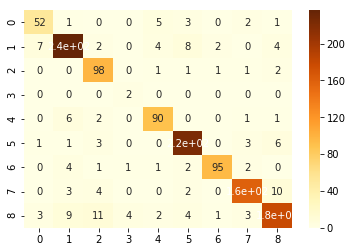

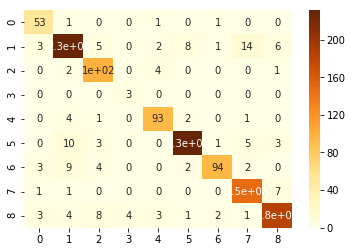

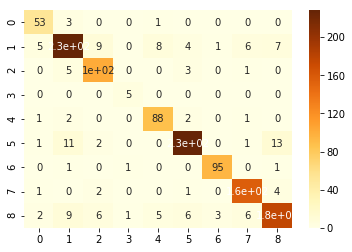

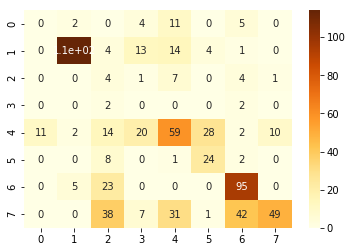

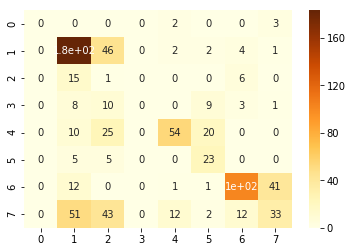

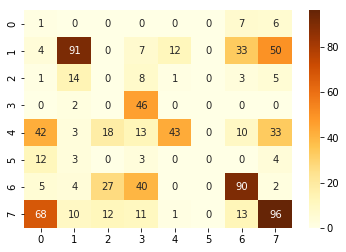

In [22]:
split_count = 3
folds = StratifiedKFold(n_splits=split_count, shuffle=True, random_state=1337)
folds_2 = GroupShuffleSplit(n_splits=split_count, random_state=1337)
sub_preds = np.zeros((X_test.shape[0], 9))
score_sum = 0
'''
clf = LGBMClassifier(colsample_bytree=0.03581900508076567, learning_rate=0.09308743154192588, 
                     max_bin=471, max_depth=-1, min_child_samples=50, min_child_weight=10, 
                     n_estimators=51, num_leaves=82, reg_alpha=2.0036361362515476e-07, reg_lambda=0.2069846982564452,
                     scale_pos_weight=9.05248363351552, subsample=0.9056112605172989, subsample_for_bin=368683, 
                     subsample_freq=9)
'''



#clf = RandomForestClassifier(max_depth=77, min_impurity_decrease=8.435373293206687e-08, 
#                            min_samples_leaf=10, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=170, random_state=1337, class_weight = 'balanced')

clf = RandomForestClassifier(max_depth=65, min_impurity_decrease=9.756650941323682e-08, min_samples_leaf=1, min_samples_split=3,
                              min_weight_fraction_leaf=0.0, n_estimators=300)


'''
clf = RandomForestClassifier(n_estimators = 200, n_jobs =- 1, class_weight ={0: 3810.0/189.0}, {1: 3810.0/732.0},
                            {2: 3810.0/779.0}, {3: 3810.0/21.0}, {4: 3810.0/308.0}, {5: 3810.0/363.0}, {6: 3810.0/297.0}, 
                            {7: 3810.0/514.0}, {8: 3810.0/607.0})
'''
# clf = RandomForestClassifier(n_estimators = 200, n_jobs =- 1, class_weight='balanced_subsample')

for i, (train_index, test_index) in enumerate(chain(folds.split(X_train, y_train['surface']),folds_2.split(X_train, y_train['surface'],
                                                groups=y_train['group_id']))):

    print('_'*20, i, '_'*20)
    clf.fit(X_train.iloc[train_index], y_train['surface'][train_index])
    score_sum += clf.score(X_train.iloc[test_index], y_train['surface'][test_index])
    print('train_score ', clf.score(X_train.iloc[train_index], y_train['surface'][train_index]))
    print('cv_score ', clf.score(X_train.iloc[test_index], y_train['surface'][test_index]))
    plt.figure()
    cm = confusion_matrix(clf.predict(X_train.iloc[test_index]), y_train['surface'].iloc[test_index])
    sns.heatmap(cm, annot=True, cmap="YlOrBr")
    importances = clf.feature_importances_
    indices = np.argsort(importances)
    features = X_train.columns
    
    '''
    hm = 30
    plt.figure(figsize=(7, 10))
    plt.title('Feature Importances')
    plt.barh(range(len(indices[:hm])), importances[indices][:hm], color='b', align='center')
    plt.yticks(range(len(indices[:hm])), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    '''
    

print('_'*40)
mean_cv_acc = score_sum / (split_count*2)
print('Avg CV Accuracy', mean_cv_acc)
clf.fit(X_train, y_train['surface'])
sub_preds = clf.predict_proba(X_test)
print("\n ____________CV CONF MATS____________")
SS['surface'] = le.inverse_transform(sub_preds.argmax(axis=1))
SS.to_csv('rf.csv', index=False)

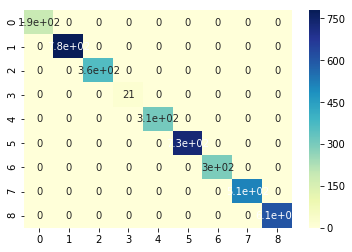

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(clf.predict(X_train), y_train['surface'])
sns.heatmap(cm, annot=True, cmap="YlGnBu")

In [ ]:
print(y_train['surface'].value_counts())

In [10]:
print(le.inverse_transform(y_train['surface'].unique()))
print(y_train['surface'].unique())

['fine_concrete' 'concrete' 'soft_tiles' 'tiled' 'soft_pvc'
 'hard_tiles_large_space' 'carpet' 'hard_tiles' 'wood']
[2 1 6 7 5 4 0 3 8]


In [ ]:
print("Training group id occurances and conf mat.")    
for i, (train_index, test_index) in enumerate(folds.split(X_train, y_train['surface'],
                                                groups=y_train['group_id'])):
    print((y_train['group_id'].iloc[test_index]).value_counts())

In [ ]:
print("\n\nCV group id counts.")    
for i, (train_index, test_index) in enumerate(folds.split(X_train, y_train['surface'],
                                                groups=y_train['group_id'])):    
    print((y_train['group_id'].iloc[test_index]).value_counts())
    
print("\n\nTraining label counts.")    
for i, (train_index, test_index) in enumerate(folds.split(X_train, y_train['surface'],
                                                groups=y_train['group_id'])):
    print((y_train['surface'].iloc[train_index]).value_counts())
    
print("\n\nCV label counts.")    
for i, (train_index, test_index) in enumerate(folds.split(X_train, y_train['surface'],
                                                groups=y_train['group_id'])):    
    print((y_train['surface'].iloc[test_index]).value_counts())